In [50]:
import pandas as pd
import numpy as np

In [51]:
#Cooling system cleaning
df_cs = pd.read_excel('Dataset/Cooling+System+Report-06-03-22+14-29 (Masked).xlsx')
#Remove title
df_cs.columns = df_cs.iloc[2]
df_cs = df_cs.iloc[3:]
df_cs = df_cs[['LRD', 'SITE TYPE', 'COOLING SYSTEM']]
#Rename columnss
df_cs.columns = ['LRD', 'CS_Site_Type', 'Cooling_System']
df_cs.reset_index(drop = True, inplace = True) 
print(f'Size of Cooling System Dataset: ', df_cs.shape)
df_cs

Size of Cooling System Dataset:  (13317, 3)


,LRD,CS_Site_Type,Cooling_System
0,LRD24,Vacant Land,HEX
1,LRD151,Vacant Land,HEX
2,LRD1784,Vacant Land,HEX
3,LRD1784,Vacant Land,HEX
4,LRD1786,Vacant Land,HEX
...,...,...,...
13312,LRD25444,Vacant Land,HEX
13313,LRD25450,Vacant Land,HEX
13314,LRD25453,Rooftop,HEX
13315,LRD25454,Vacant Land,HEX


In [52]:
#DC battery cleaning
df_dc = pd.read_excel('Dataset/DC+Battery+Report-06-03-22+14-30 (Masked).xlsx')
df_dc.columns = df_dc.iloc[3]
df_dc = df_dc.iloc[4:]
df_dc = df_dc[['LRD', 'Battery Capacity (Ah)',  'Battery Technology', 'Administrative Status', 'Battery Brand', 'Total bank (Quantity)', 'Total Current Load (Reading at Rectifier controller Display or clamp meter at +ve battery terminal) (Amp)']]
df_dc.columns = ['LRD', 'DC_Capacity',  'DC_Technology', 'DC_Admin_Status', 'DC_Brand', 'Total_Bank', 'DC_Total_Current_Load']
df_dc.replace({'155': '150'}, regex=True, inplace=True)
df_dc.reset_index(drop = True, inplace = True) 
print(f'Size of DC Battery Dataset: ', df_dc.shape)
#change object type to numeric
df_dc['DC_Total_Current_Load'] = pd.to_numeric(df_dc['DC_Total_Current_Load'], errors='coerce')
#based on author's note in csv, total current load > 4, battery is unusable (not normal)
df_dc['DC_Admin_Status'] = np.where(df_dc['DC_Total_Current_Load'] > 4, "Active", "Decommissioned")
df_dc.drop('DC_Total_Current_Load', inplace=True, axis=1)
df_dc

Size of DC Battery Dataset:  (10010, 7)


,LRD,DC_Capacity,DC_Technology,DC_Admin_Status,DC_Brand,Total_Bank
0,LRD22703,60,Lithium,Decommissioned,Enersys,2
1,LRD1786,150,VRLA,Active,MSB,1
2,LRD2250,150,VRLA,Active,Narada,2
3,LRD12932,150,VRLA,Decommissioned,Enersys,1
4,LRD2249,150,VRLA,Decommissioned,Narada,1
...,...,...,...,...,...,...
10005,LRD11374,100,Lithium,Active,Narada,1
10006,LRD11406,150,VRLA,Decommissioned,Others,1
10007,LRD11432,150,VRLA,Active,Sacredsun,1
10008,LRD11475,150,VRLA,Decommissioned,Sacredsun,1


In [53]:
#Battery Health
df_bh = pd.read_excel('Dataset/Battery Health Check (2) (Masked).xlsx')
df_bh.columns = df_bh.iloc[1]
df_bh = df_bh.iloc[2:]
df_bh = df_bh[['State','Site Name', 'Backup Hour' ,'Aging Days']]
df_bh.rename(columns = {'Site Name' : 'LRD'}, inplace = True)
#replace State for remaining columns
df_bh["State"].fillna( method ='ffill', inplace = True)
#drop entries where aging days is null
df_bh.dropna(subset = {'Aging Days'}, inplace = True)
df_bh.reset_index(drop = True, inplace = True)
#create new columns power count event and map
temp = df_bh['LRD'].value_counts()
temp = temp.to_dict()
df_bh['Power Event Count'] = df_bh['LRD'].map(temp)


# print(df_bh.shape)
df_bh

1,State,LRD,Backup Hour,Aging Days,Power Event Count
0,NEGERI SEMBILAN,LRD2246,>30min to <1hr,1774,2
1,NEGERI SEMBILAN,LRD2246,>30min to <1hr,1774,2
2,NEGERI SEMBILAN,LRD2274,>2hrs to <3hrs,932,1
3,NEGERI SEMBILAN,LRD3701,>3hrs to <4hrs,2105,13
4,NEGERI SEMBILAN,LRD3701,>2hrs to <3hrs,2105,13
...,...,...,...,...,...
2769,NEGERI SEMBILAN,LRD3779,>2hrs to <3hrs,480,4
2770,NEGERI SEMBILAN,LRD3779,>1hr to <2hrs,480,4
2771,NEGERI SEMBILAN,LRD12068,>3hrs to <4hrs,447,3
2772,NEGERI SEMBILAN,LRD12068,>3hrs to <4hrs,447,3


In [54]:
#problem 1 dataset
#Inital dataset, before one-hot, SMOTE and features selection
#Determine outliers to remove

merge_BatteryLifespan = pd.merge(df_bh, df_dc ,how = "inner", on =["LRD"])
merge_BatteryLifespan = pd.merge(merge_BatteryLifespan, df_cs ,how = "left", on =["LRD"])
merge_BatteryLifespan.drop_duplicates(subset=None, keep='first', inplace=True)

merge_BatteryLifespan.dropna(inplace=True)
lst = ['WP LABUAN', 'WP PUTRAJAYA', 'PERLIS']
merge_BatteryLifespan = merge_BatteryLifespan[~merge_BatteryLifespan['State'].isin(lst)]
lst = ['Haze', 'Sunstone', 'Supersave', 'Sacredsun', "Sonnenschein",  "Hoppecke"]
merge_BatteryLifespan = merge_BatteryLifespan[~merge_BatteryLifespan['DC_Brand'].isin(lst)]

lst = ['5', '6']
merge_BatteryLifespan = merge_BatteryLifespan[~merge_BatteryLifespan['Total_Bank'].isin(lst)]
merge_BatteryLifespan = merge_BatteryLifespan[~merge_BatteryLifespan['CS_Site_Type'].isin(["Inbuilding"])]
temp = {
    'Decommissioned': 0 ,'Active': 1,
    'Lithium': 0, 'VRLA': 1,
    'Air Conditioner': 0, "FCU": 1, 'FCU Hybrid': 2, 'HEX': 3, 
    'Vacant Land': 0, 'Rooftop': 1, 'Inbuilding': 2,
    'Enersys': 0, 'Haze': 1, "Hoppecke": 2, "Huawei": 3, "MSB": 4, 'Narada': 5, "Sacredsun": 6, "Sonnenschein": 7, "Sunstone": 8, "Supersave": 9,
    'JOHOR': 0, 'KEDAH': 1, 'KELANTAN' : 2, 'MELAKA': 3, 'NEGERI SEMBILAN': 4, 'PAHANG': 5, 'PERAK': 6, 'PERLIS':7, 'PULAU PINANG':8, 'SABAH':9, 
    'SARAWAK':10, 'SELANGOR':11,'TERENGGANU':12, 'WP KUALA LUMPUR':13, 'WP LABUAN':14, 'WP PUTRAJAYA':15,
     '<15min' : 0, '>15min to <30min' : 1, '>30min to <1hr' : 2,'>1hr to <2hrs' : 3,'>2hrs to <3hrs' : 4, '>3hrs to <4hrs' : 5, '>4hrs' : 6
}

merge_BatteryLifespan.replace(temp, inplace = True) 
cols = ['Aging Days', 'DC_Capacity']
merge_BatteryLifespan[cols] = merge_BatteryLifespan[cols].apply(pd.to_numeric, errors='coerce', axis=1)
merge_BatteryLifespan = merge_BatteryLifespan[merge_BatteryLifespan['DC_Capacity'] != 200]
merge_BatteryLifespan = merge_BatteryLifespan[merge_BatteryLifespan["Aging Days"] <= 2100 ] 
merge_BatteryLifespan = merge_BatteryLifespan[merge_BatteryLifespan["Aging Days"] >= 700 ]   
merge_BatteryLifespan.reset_index(drop = True, inplace= True)
merge_BatteryLifespan

,State,LRD,Backup Hour,Aging Days,Power Event Count,DC_Capacity,DC_Technology,DC_Admin_Status,DC_Brand,Total_Bank,CS_Site_Type,Cooling_System
0,4,LRD2246,2,1774,2,150,1,1,5,2,0,0
1,4,LRD2274,4,932,1,150,0,1,3,3,1,2
2,4,LRD3749,1,1524,5,150,1,1,5,1,0,0
3,4,LRD3749,0,1524,5,150,1,1,5,1,0,0
4,4,LRD3921,6,1117,1,150,1,1,0,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1400,3,LRD14115,0,2065,3,100,1,1,4,2,1,3
1401,3,LRD16749,4,1748,1,100,1,1,0,2,0,3
1402,3,LRD19243,4,1420,3,100,1,1,5,2,0,3
1403,3,LRD19243,3,1420,3,100,1,1,5,2,0,3


In [55]:
# pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [56]:
#Initial pandas profilling
from pandas_profiling import ProfileReport 
profile = ProfileReport(merge_BatteryLifespan, explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [57]:
temp = merge_BatteryLifespan['DC_Capacity'].value_counts()
print(temp)

150    1235
100     170
Name: DC_Capacity, dtype: int64


In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression

#Initial prediction using Linear Regression
X =  np.array(merge_BatteryLifespan[["Power Event Count",	"DC_Admin_Status",	"DC_Brand",	"DC_Capacity",	"Total_Bank", "DC_Technology",	"CS_Site_Type",	"Cooling_System"]])
y =  np.array(merge_BatteryLifespan[["Aging Days"]])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 123)
LR = LinearRegression()
# fitting the training data
LR.fit(X_train,y_train)
# initial prediction
y_prediction =  LR.predict(X_test)

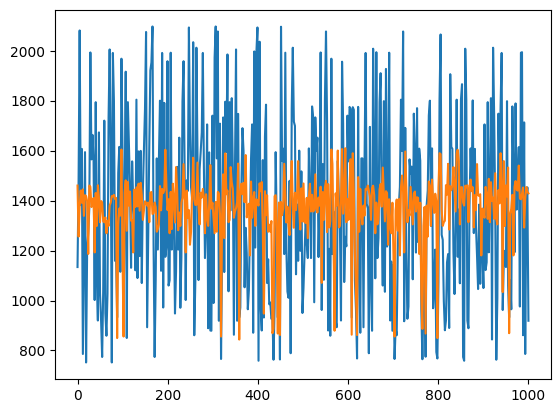

In [59]:
import matplotlib.pyplot as plt

#Plot the distribution of prediction vs actual values

x1 = np.linspace(0, 1000, num=422)
y1 = y_test
# plotting the line 1 points 
plt.plot(x1, y1, label = "line 1")
  
# line 2 points
x2 = np.linspace(0, 1000, num=422)
y2 = y_prediction
# # plotting the line 2 points 
plt.plot(x2, y2, label = "line 2")
plt.show()


We can clearly see that there are many outliers in the Actual Aging Days (Blue) vs the predicted Aging Days in which most are evenly distributed. (Orange)

In [60]:
import math
#To determine which outliers to remove

r2_list = []
rmean_squared_error = []
mae = [] 
x = []

a = 2900
for i in range(0,20):
   merge_BatteryLifespan = merge_BatteryLifespan[merge_BatteryLifespan["Aging Days"] <= a ] #Varies to determine optimal uper boundary
   merge_BatteryLifespan = merge_BatteryLifespan[merge_BatteryLifespan["Aging Days"] >= 700 ] #Assume 700 is the lower boundary
   X =  np.array(merge_BatteryLifespan[["State", "Power Event Count",	"DC_Admin_Status",	"DC_Brand",	"DC_Capacity",	"Total_Bank", "DC_Technology",	"CS_Site_Type",	"Cooling_System"]])
   y =  np.array(merge_BatteryLifespan[["Aging Days"]])
   X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 123)
   
   LR = LinearRegression()
   # fitting the training data
   LR.fit(X_train,y_train)
   y_prediction =  LR.predict(X_test)
   x.append(2900 - (i*100))
   mae.append(mean_absolute_error(y_test, y_prediction))
   r2_list.append(r2_score(y_test, y_prediction))
   #Append scores of each loop for plotting and justification 
   rmean_squared_error.append(math.sqrt(mean_squared_error(y_test, y_prediction)))
   a -= 100
   

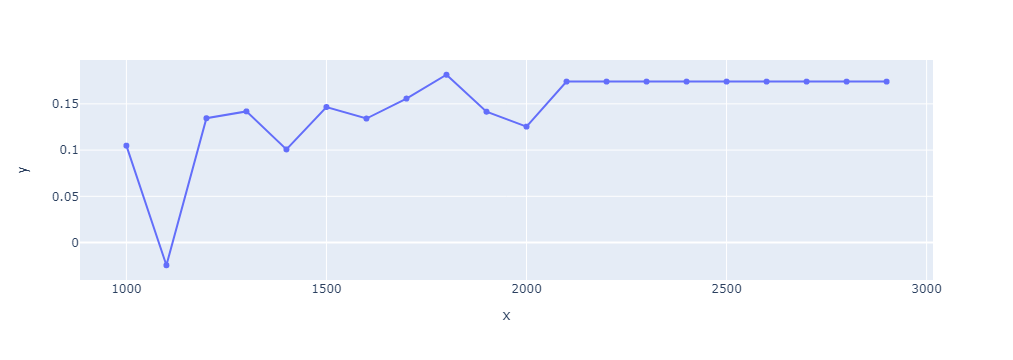

In [61]:
import matplotlib.pyplot as plt
import plotly.express as px

#Accuracy vs outliers upper boundary plot
x1 = x
y1 = r2_list 

fig = px.line(x=x1, y=y1, markers=True)
fig.show()


In [90]:
#Avoid running this cell
#Initial Accuracy before SMOTE, ONE-HOT, Ensemble Learning ,K-FOLD
#Feature selection 
#Removing state feature from DC health check

# X =  np.array(merge_BatteryLifespan[["State", "Power Event Count",	"DC_Admin_Status",	"DC_Brand",	"DC_Capacity",	"Total_Bank", "DC_Technology",	"CS_Site_Type",	"Cooling_System"]])
# y =  np.array(merge_BatteryLifespan[["Aging Days"]])
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# LR = LinearRegression()
# LR.fit(X_train,y_train)
# y_pred =  LR.predict(X_test)
# print("R2 score with state feature:", r2_score(y_test, y_pred))

# X =  np.array(merge_BatteryLifespan[["Power Event Count",	"DC_Admin_Status",	"DC_Brand",	"DC_Capacity",	"Total_Bank", "DC_Technology",	"CS_Site_Type",	"Cooling_System"]])
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)
# LR.fit(X_train,y_train)
# y_pred =  LR.predict(X_test)
# print("R2 score without state feature:", r2_score(y_test, y_pred))

R2 score with state feature: 0.03141835774226642
R2 score without state feature: 0.11282452124224918


We can clearly see that 2100 is the optimal boundary as accuracies only varies sligthly compare to 1800. We choose 2100 to avoid removing too much data. 
Finally, we decided to remove outliers where 700< aging days <2100

In [73]:
# pip install mlxtend --upgrade

In [88]:
# Determine bias and variance for ensemble learning
from sklearn.linear_model import Ridge
from mlxtend.evaluate import bias_variance_decomp

bucket='maxis-problem'

s3uri = 's3://sagemaker-ap-southeast-1-117213039920/finaldata16722/output_1657956822/part-00000-a0ef82c6-52e1-4393-b500-6626b5b0a2e6-c000.csv'

df_newest = pd.read_csv(s3uri)
df_newest

X = df_newest.drop(['LRD', 'Aging Days'], axis = 1)
y = df_newest['Aging Days']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#Ridge regression using pipeliner
pipeline = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
pipeline.fit(X_train, y_train)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        pipeline, X_train.values, y_train.values, X_test.values, y_test.values, 
        loss='mse')

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 56540.653
Average bias: 56066.082
Average variance: 474.570


In [89]:
#Justification for error metrics selection 
from sklearn.model_selection import cross_val_score

final_prediction = pipeline.predict(X_test)
#using Aging Days as y output
print("Error metrics using Aging Days: ")
print("mae: ", mean_absolute_error(y_test, final_prediction))
print("r2: ", r2_score(y_test, final_prediction))
print("rmse: ", math.sqrt(mean_squared_error(y_test, final_prediction)))


#using Aging Years as y output
#divide Aging Days with 365
y_test = y_test/365
final_prediction = final_prediction / 365

print("\nError metrics using Aging Years: ")
print("mae: ", mean_absolute_error(y_test, final_prediction))
print("r2: ", r2_score(y_test, final_prediction))
print("rmse: ", math.sqrt(mean_squared_error(y_test, final_prediction)))



Error metrics using Aging Days: 
mae:  164.93074456900686
r2:  0.5880075508072624
rmse:  234.91379659289217

Error metrics using Aging Years: 
mae:  0.45186505361371754
r2:  0.5880075508072623
rmse:  0.6435994427202525


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

